In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import medfilt
from scipy.signal import argrelmin, argrelmax, argrelextrema
from astropy.table import Table,vstack
import pickle as pkl

In [67]:
##   a + bx + cx^2 + dx^3 + ex^4 + fx^5 + ...
## for example: [1000.,1.,0.,0.,0.,0.]  ->  1000 + 1x + 0x^2 + 0x^3 + 0x^4 + 0x^5
init_poly_coeffs = [1000.,1.]#,0.,0.] #[1000.,1.,0.,0.,0.,0.] 

## number of calibrations to use in automated search
ncalib_lines = 18
nchoose_lines = 16 # nCr -> 10C8 = 60 possibilities

## number of test points to use in automated search
ntest_lines = 20
#nchoose_lines = 7  # nCr -> 8C7 = 8 possibilities

In [89]:
def recursive_poly(x,*reversed_coeffs):
    order = len(reversed_coeffs)-1
    if order == 0:
        return reversed_coeffs
    elif order == 1:
        return np.multiply(recursive_poly(x,reversed_coeffs[0]),x)+reversed_coeffs[-1]
    else:
        return np.multiply(recursive_poly(x,*(reversed_coeffs[:-1])),x)+reversed_coeffs[-1]

def poly(x,*coeffs):
    np_x = np.asarray(x)

    reversed_coeffs = list(coeffs)[::-1]
    return recursive_poly(np_x,*reversed_coeffs)

pix_to_lam = poly

In [70]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k']
best_str = 'Best found was'
alphabet = alphabet[:len(init_poly_coeffs)]

alpha_str = ''
for lett in alphabet:
    alpha_str += '\t'+lett+'={:.04e},'
    
alpha_str = alpha_str[:-1]
best_str += alpha_str

In [47]:
tabs = []
for name in ['Argon','Neon','HgNe','Xenon']:
    tab = Table.read('./lamp_linelists/osmos_{}.dat'.format(name),format='ascii.basic',\
                     data_start=0,names=['wavelength','element','flux'])
    tabs.append(tab)
    
calib_linelist = vstack(tabs)
calib_linelist.sort('wavelength')
#for tab in tabs[1:]:
#    merged_table.
dat = calib_linelist['wavelength'].data
possible_dups = np.where(np.abs(dat[1:]-dat[:-1]) < 0.001)[0]

for test_dup in possible_dups[::-1]:
    print(test_dup,calib_linelist['element'][test_dup],calib_linelist['element'][test_dup+1],calib_linelist['flux'][test_dup],calib_linelist['flux'][test_dup+1])
    if ((calib_linelist['element'][test_dup] == calib_linelist['element'][test_dup+1]) &\
        (calib_linelist['flux'][test_dup] == calib_linelist['flux'][test_dup+1])):
        calib_linelist.remove_row(test_dup)
        print("Removing {}".format(test_dup))

193 NeI NeI 85000 85000
Removing 193
191 NeI NeI 34000 34000
Removing 191
187 NeI NeI 100000 100000
Removing 187
173 NeI NeI 700 700
Removing 173
170 NeI NeI 5000 5000
Removing 170
164 NeI NeI 10000 10000
Removing 164
160 NeI NeI 1000 1000
Removing 160
158 NeI NeI 15000 15000
Removing 158
153 NeI NeI 20000 20000
Removing 153
150 NeI NeI 10000 10000
Removing 150
148 NeI NeI 10000 10000
Removing 148
144 NeI NeI 1000 1000
Removing 144
141 NeI NeI 10000 10000
Removing 141
139 NeI NeI 10000 10000
Removing 139
130 NeI NeI 10000 10000
Removing 130
127 NeI NeI 10000 10000
Removing 127
122 NeI NeI 3000 3000
Removing 122
120 NeI NeI 10000 10000
Removing 120
115 NeI NeI 10000 10000
Removing 115
113 NeI NeI 6000 6000
Removing 113
104 NeI NeI 10000 10000
Removing 104
100 NeI NeI 20000 20000
Removing 100
92 NeI NeI 7000 10


In [48]:
calib_linelist.show_in_notebook()

idx,wavelength,element,flux
0,3443.83,XeI,10
1,3472.5706,NeI,5000
2,3520.4714,NeI,10000
3,3593.5263,NeI,5000
4,3650.158,HgI,9000
5,3654.842,HgI,3000
6,3662.887,HgI,500
7,3663.284,HgI,2000
8,3834.679,ArI,7
9,3877.2,XeI,10


In [49]:
calib_wavelengths = calib_linelist['wavelength'].data
calib_fluxs = calib_linelist['flux'].data #np.random.randint(10,1000,len(wavelengths))

In [50]:
if len(calib_wavelengths) < ncalib_lines:
    ncalib_lines = len(calib_wavelengths)

In [51]:
rankings = np.argsort(calib_fluxs)[::-1]
top_flux_inds = rankings[:ncalib_lines]
backsorted_topfluxes = np.sort(top_flux_inds)

calib_waves_shortlist = calib_wavelengths[backsorted_topfluxes]
calib_fluxs_shortlist = calib_fluxs[backsorted_topfluxes]

minflux = np.min(calib_fluxs_shortlist)
if minflux < 1.1:
    calib_log_fluxs_shortlist = np.log(calib_fluxs_shortlist-np.min(calib_fluxs_shortlist)+1.1)
else:
    calib_log_fluxs_shortlist = np.log(calib_fluxs_shortlist)
    
calib_sigma_shortlist = calib_log_fluxs_shortlist/np.max(calib_log_fluxs_shortlist)
# print(calib_fluxs_shortlist)
# print(calib_log_fluxs_shortlist)
# print(calib_sigma_shortlist)
# print(calib_fluxs_shortlist/np.max(calib_fluxs_shortlist))
del rankings,top_flux_inds,backsorted_topfluxes,calib_log_fluxs_shortlist,minflux

[3520.4714 4046.565  4358.335  4671.2258 5341.0938 5400.5616 5852.4878
 5881.895  6217.2812 6266.4952 6334.4276 6382.9914 6402.248  6506.5277
 6598.9528 6929.4672 7024.05   7032.4128]


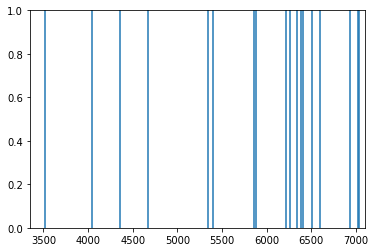

In [52]:
plt.figure()
print(calib_waves_shortlist)
for lin in calib_waves_shortlist:
    plt.axvline(lin)

In [53]:
apcut_data = {}
with open('pkldump.pkl','rb') as pdump:
    apcut_data = pkl.load(pdump)

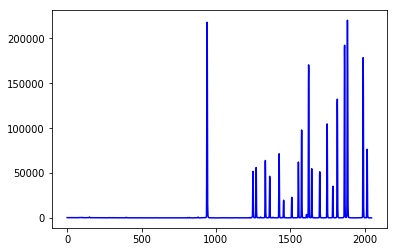

In [54]:
test_spectra = apcut_data['comp']['r'][628]['r101']
size_ccd = len(test_spectra)
plt.figure()
plt.plot(range(len(test_spectra)),test_spectra,'b-')

[ 941 1250 1271 1333 1362 1425 1456 1511 1555 1577 1624 1645 1699 1748
 1787 1817 1866 1885 1991 2017] [218042.85888   51897.6606    56225.031225  64058.310825  46465.6854
  71584.1427    19808.4243    23101.5156    62320.77285   98020.50195
 170541.222     54870.8658    51473.4336   104839.8618    35388.1086
 132426.058875 192393.2913   220276.022925 178620.5877    76598.17005 ]


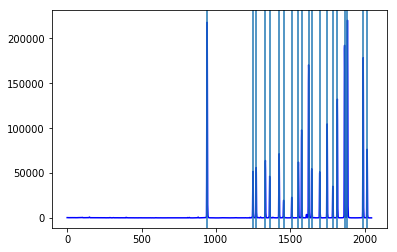

In [55]:
test_pixel_peaks = argrelmax(test_spectra)[0]
test_flux_peaks = test_spectra[test_pixel_peaks]
rankings = np.argsort(test_flux_peaks)[::-1]
top_flux_inds = rankings[:ntest_lines]
backsorted_topfluxes = np.sort(top_flux_inds)

test_pixel_peaks_shortlist = test_pixel_peaks[backsorted_topfluxes]
test_flux_peaks_shortlist = test_flux_peaks[backsorted_topfluxes]
print(test_pixel_peaks_shortlist,test_flux_peaks_shortlist)

plt.figure()
plt.plot(range(len(test_spectra)),test_spectra,'b-')
for pix in test_pixel_peaks_shortlist:
    plt.axvline(pix)

In [56]:
print(test_pixel_peaks_shortlist)
print(calib_waves_shortlist)

[ 941 1250 1271 1333 1362 1425 1456 1511 1555 1577 1624 1645 1699 1748
 1787 1817 1866 1885 1991 2017]
[3520.4714 4046.565  4358.335  4671.2258 5341.0938 5400.5616 5852.4878
 5881.895  6217.2812 6266.4952 6334.4276 6382.9914 6402.248  6506.5277
 6598.9528 6929.4672 7024.05   7032.4128]


<Figure size 432x288 with 0 Axes>

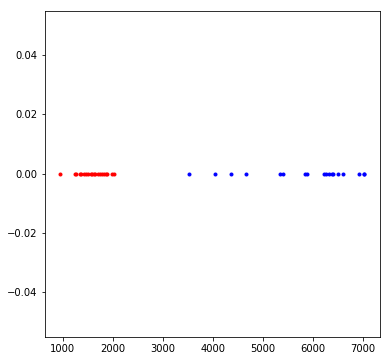

In [57]:
ycalibs = np.zeros(ncalib_lines)
ytests = np.zeros(ntest_lines)
plt.figure(),plt.subplots(figsize=(6,6))
plt.plot(calib_waves_shortlist,ycalibs,'b.')
plt.plot(test_pixel_peaks_shortlist,ytests,'r.')
plt.show()

In [68]:
from itertools import combinations
all_calib_inds = np.arange(ncalib_lines).astype(int)
all_param_combos = []
best_fitted_calib_waves = []
best_fitted_test_pix = []
best_params = ()
lowest_chisq = 1e6
for current_ind_selection_tup in combinations(all_calib_inds, nchoose_lines):
    current_ind_selection = list(current_ind_selection_tup)
    calib_waves = calib_waves_shortlist[current_ind_selection]
    calib_sigs  = calib_sigma_shortlist[current_ind_selection]
    for test_pix in combinations(test_pixel_peaks_shortlist,nchoose_lines):
        current_params,param_covar = curve_fit(pix_to_lam,test_pix,\
                                            calib_waves,p0=init_poly_coeffs,\
                                            sigma=calib_sigs,maxfev=int(1e5))
        all_param_combos.append(current_params)
        test_waves = poly(test_pix,*current_params)
        diff_waves = test_waves-calib_waves
        chisq = np.sum(diff_waves*diff_waves)
        if chisq < lowest_chisq:
            lowest_chisq = chisq
            best_params = current_params
            best_fitted_calib_waves = calib_waves
            best_fitted_test_pix = test_pix

print(best_str.format(*best_params))

IndexError: tuple index out of range

<Figure size 432x288 with 0 Axes>

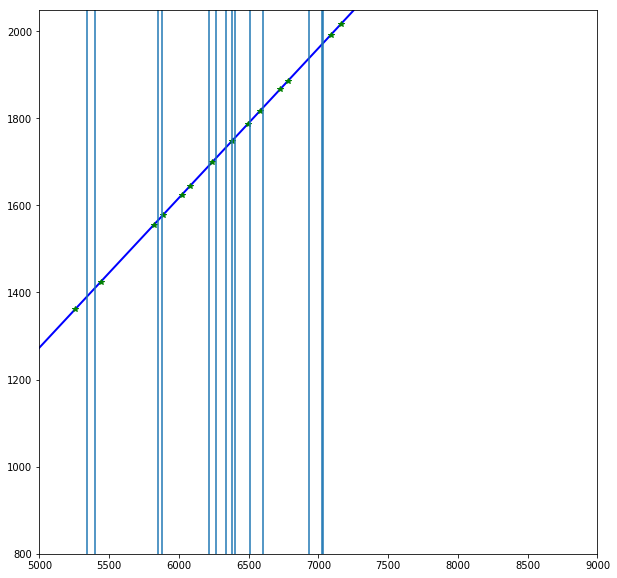

In [72]:
pixels = np.arange(size_ccd)
bestfit_lams = poly(pixels,*best_params)

bestfit_lams_testlines = poly(best_fitted_test_pix,*best_params)

plt.figure(),plt.subplots(figsize=(10,10))
plt.plot(bestfit_lams,pixels,'b-',linewidth=2)
plt.plot(bestfit_lams_testlines,best_fitted_test_pix,'g*')
for wave in best_fitted_calib_waves:
    plt.axvline(wave)
plt.ylim(800,size_ccd)
plt.xlim(5000,9000)
plt.show()

<Figure size 432x288 with 0 Axes>

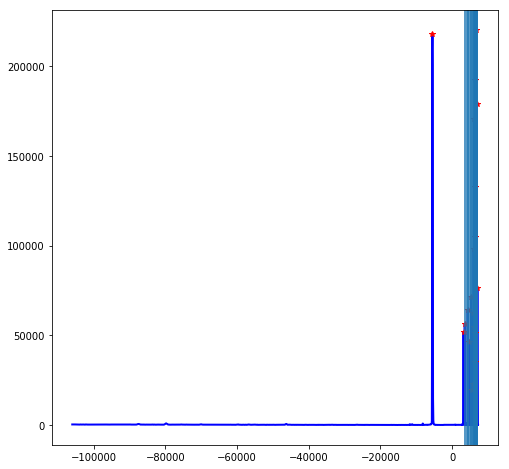

In [60]:
plt.figure(),plt.subplots(figsize=(8,8))
plt.plot(bestfit_lams,test_spectra,'b-',linewidth=2)
plt.plot(bestfit_lams_testlines,test_spectra[test_pixel_peaks_shortlist],'r*')
for wave in calib_waves_shortlist:
    plt.axvline(wave)
#plt.ylim(0,10000)
#plt.xlim(5000,7500)
plt.show()

<Figure size 432x288 with 0 Axes>

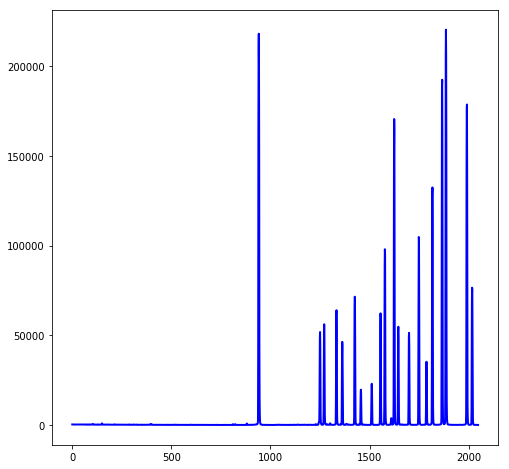

In [61]:
plt.figure(),plt.subplots(figsize=(8,8))
plt.plot(range(size_ccd),test_spectra,'b-',linewidth=2)

plt.show()

In [95]:
%timeit poly(4,1,2,4,2,7,8)

11.3 µs ± 399 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [96]:
%timeit 1+(2*4)+(4*(4**2))+(2*(4**3))+(7*(4**4))+(8*(4**5))

11.9 ns ± 0.161 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [100]:
xs = np.arange(20)

In [101]:
%timeit poly(xs,1,2,4,2,7,8)

11.8 µs ± 375 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [102]:
%timeit 1+(2*xs)+(4*(xs**2))+(2*(xs**3))+(7*(xs**4))+(8*(xs**5))

9.25 µs ± 338 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
